In [259]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf
using MLUtils
using IterTools: ncycle
using BSON: @save, @load

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")
include("src/neural_ode/regularization.jl")
include("src/rom/pod.jl")

Main.POD

# Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

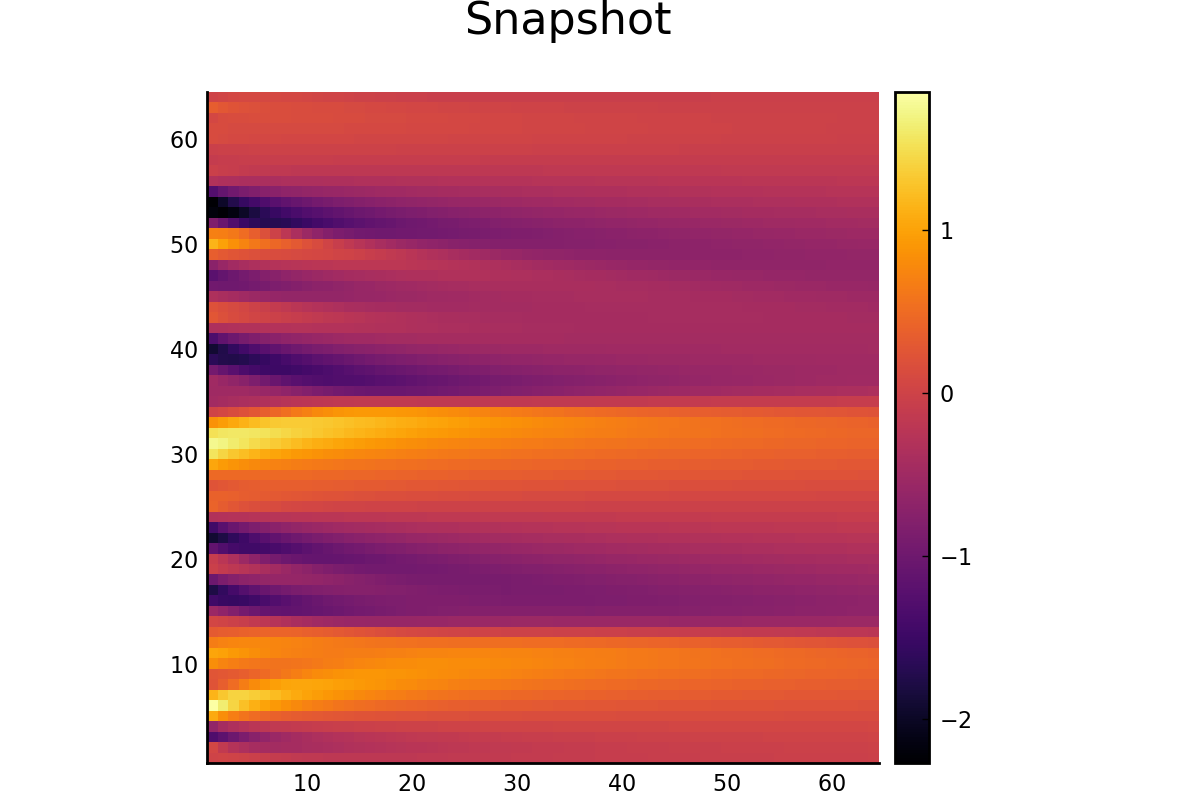

In [151]:
t_max = 0.5;
t_min = 0.;
x_max = pi;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.03;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);


u0 = InitialFunctions.high_dim_random_init(t, x, 28);
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

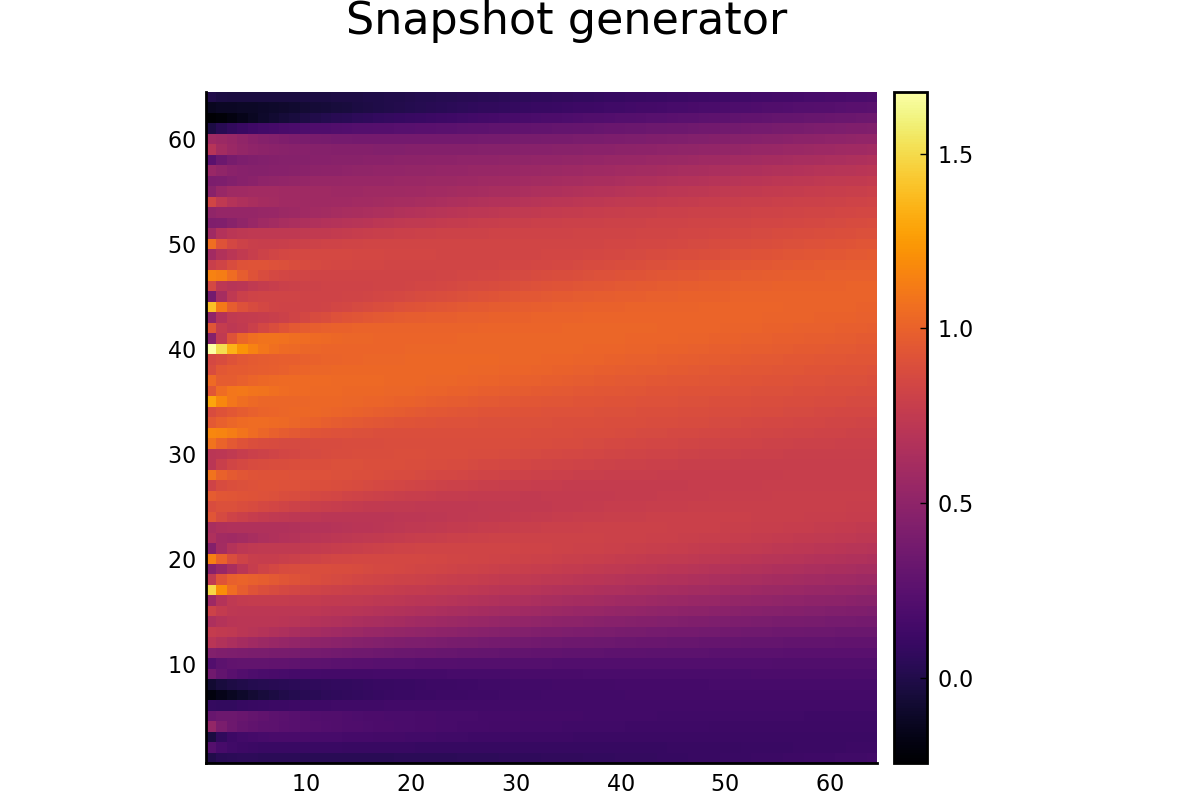

In [113]:
ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 1);
GraphicTools.show_state(u_a, "Snapshot generator")

In [ ]:
# bas = POD.generate_pod_basis(u, true);
# ϕ = bas.modes;
# res = Equations.galerkin_projection(t, u, ϕ, nu, dx, dt);
# GraphicTools.show_state(res, "")

In [162]:
# dataset = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 128, 2, 1, false, "./src/dataset/burgers_high_dim_training_set.jld2", "training_set");
high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];

Item1Item2Item3Item4Item5Item6Item7Item8Item9Item10Item11Item12Item13Item14Item15Item16Item17Item18Item19Item20Item21Item22Item23Item24Item25Item26Item27Item28Item29Item30Item31Item32Item33Item34Item35Item36Item37Item38Item39Item40Item41Item42Item43Item44Item45Item46Item47Item48Item49Item50Item51Item52Item53Item54Item55Item56Item57Item58Item59Item60Item61Item62Item63Item64Item65Item66Item67Item68Item69Item70Item71Item72Item73Item74Item75Item76Item77Item78Item79Item80Item81Item82Item83Item84Item85Item86Item87Item88Item89Item90Item91Item92Item93Item94Item95Item96Item97Item98Item99Item100Item101Item102Item103Item104Item105Item106Item107Item108Item109Item110Item111Item112Item113Item114Item115Item116Item117Item118Item119Item120Item121Item122Item123Item124Item125Item126Item127Item128

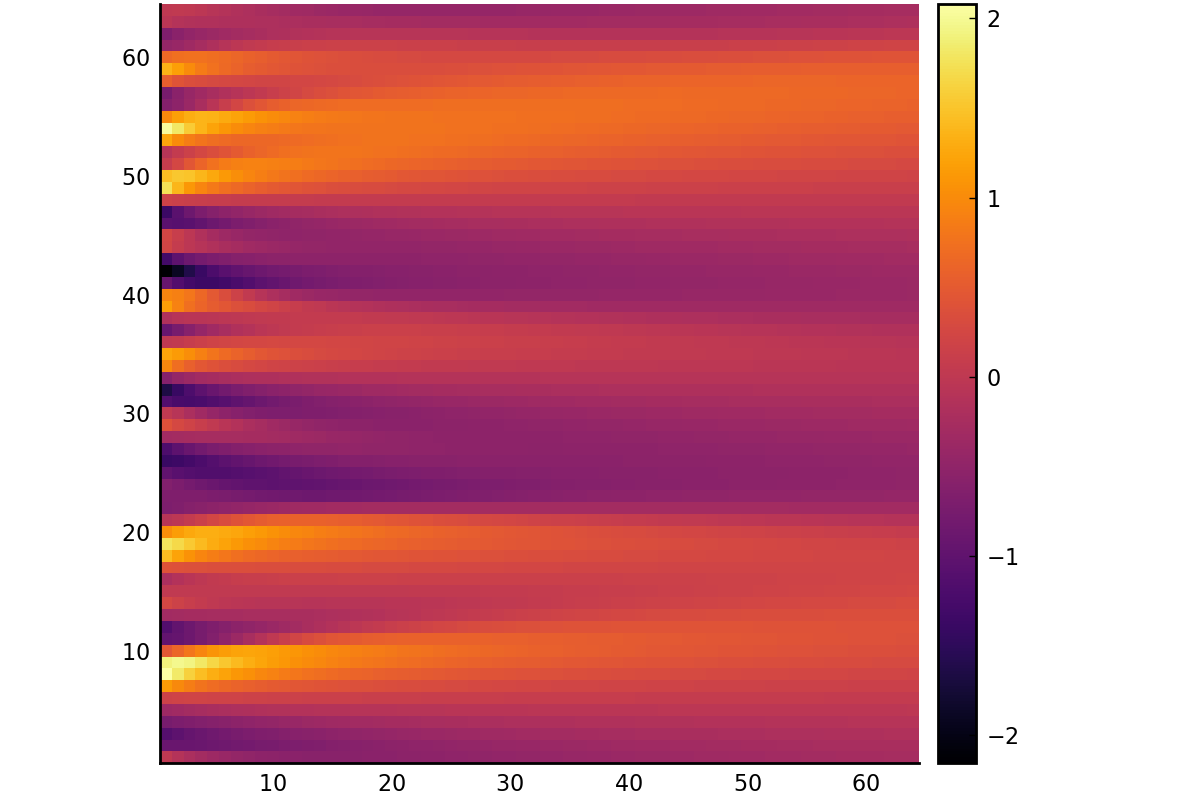

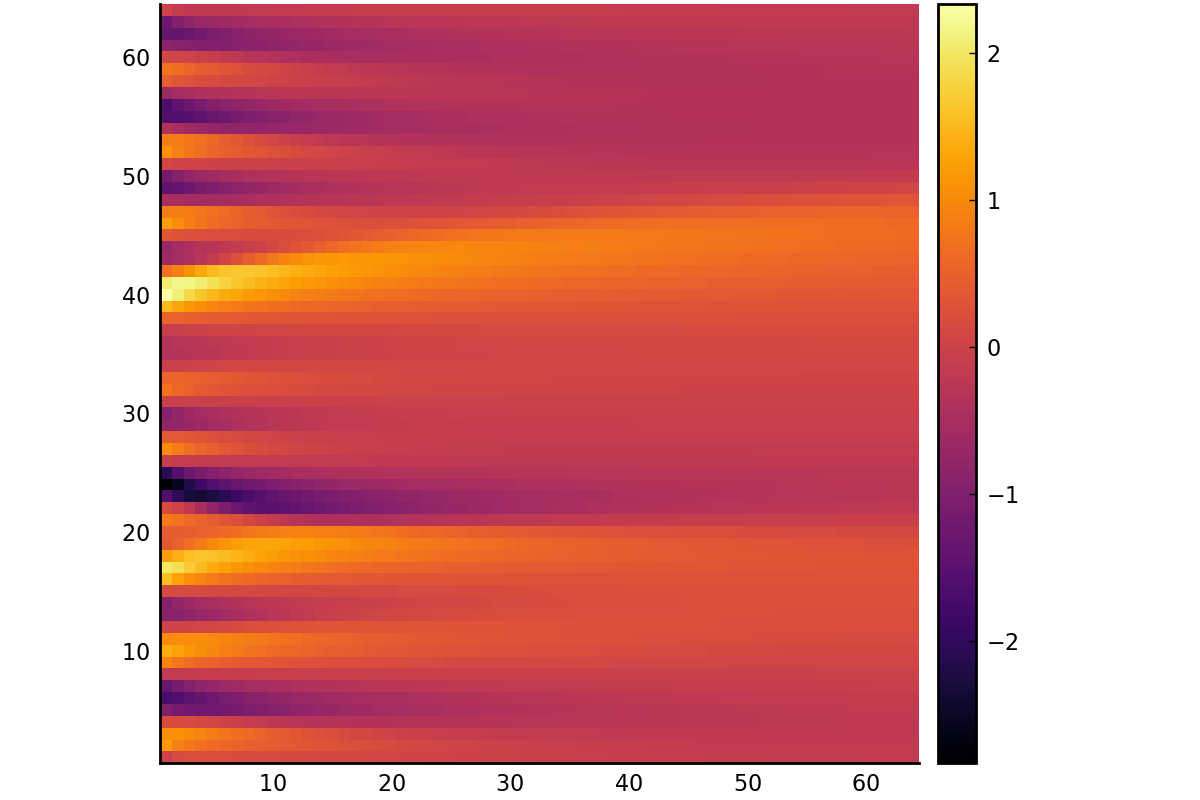

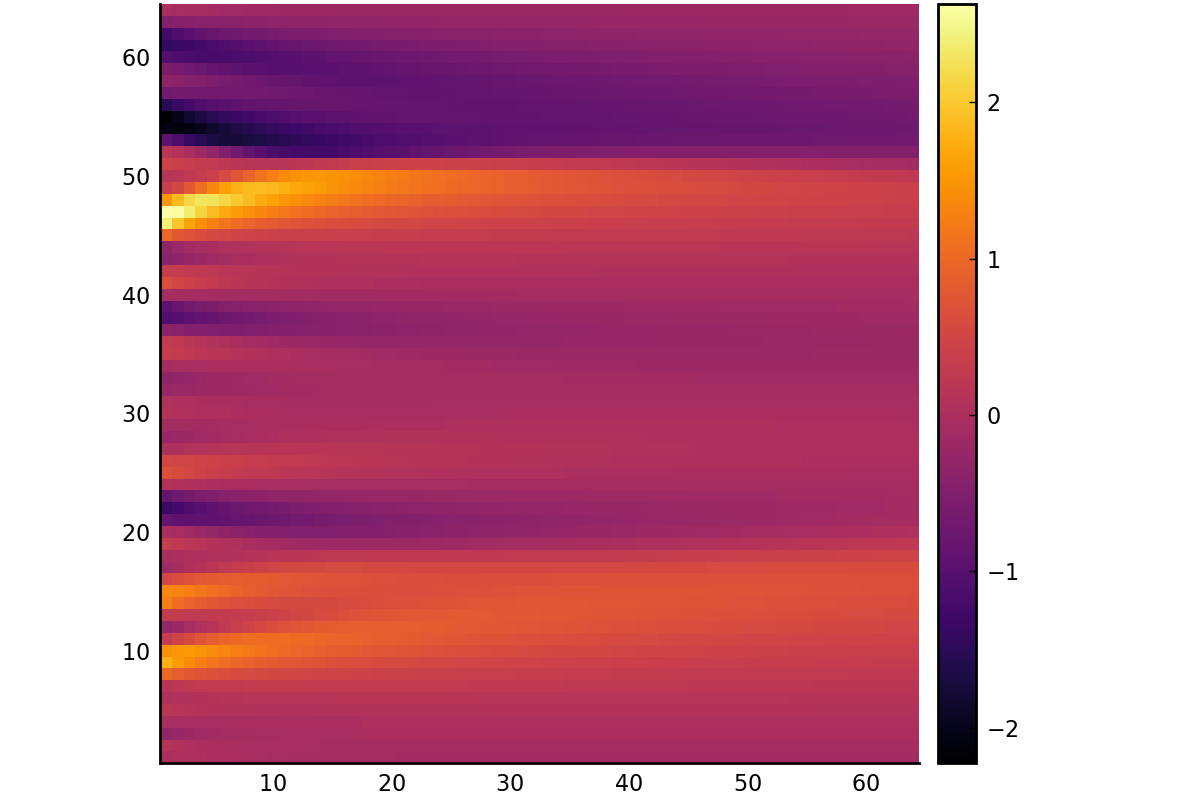

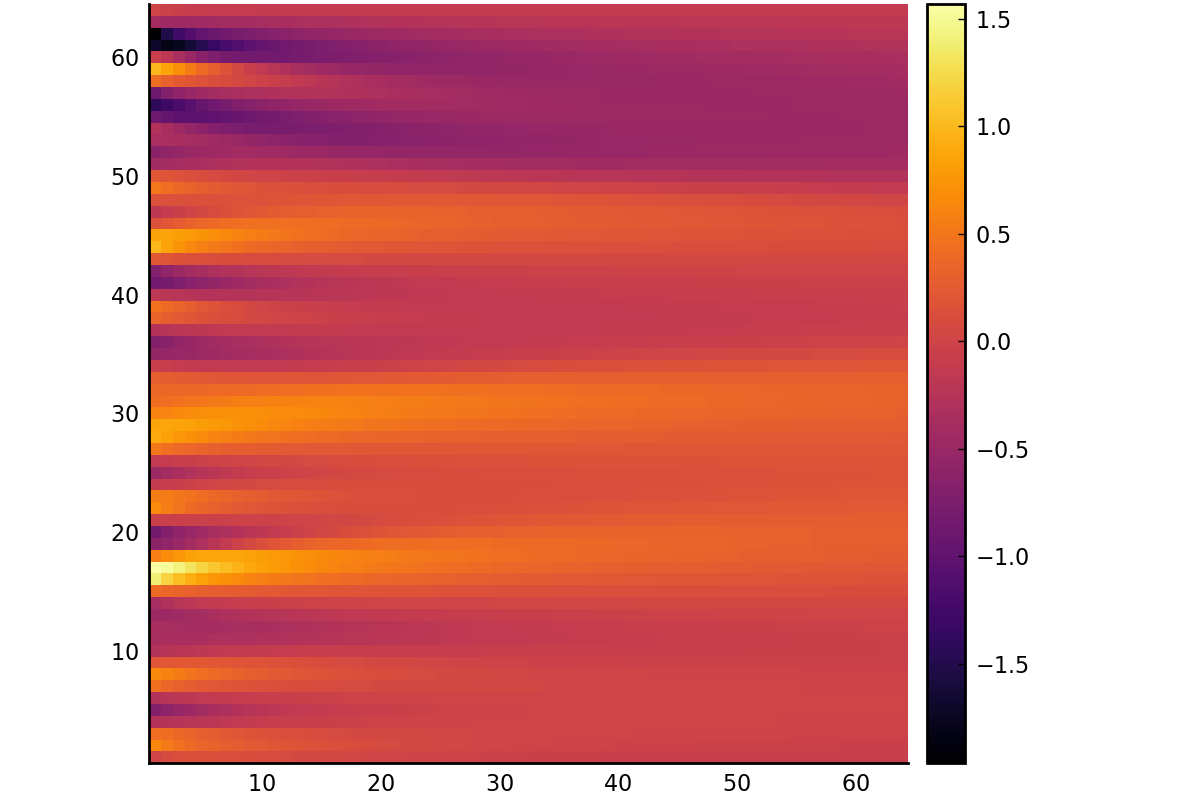

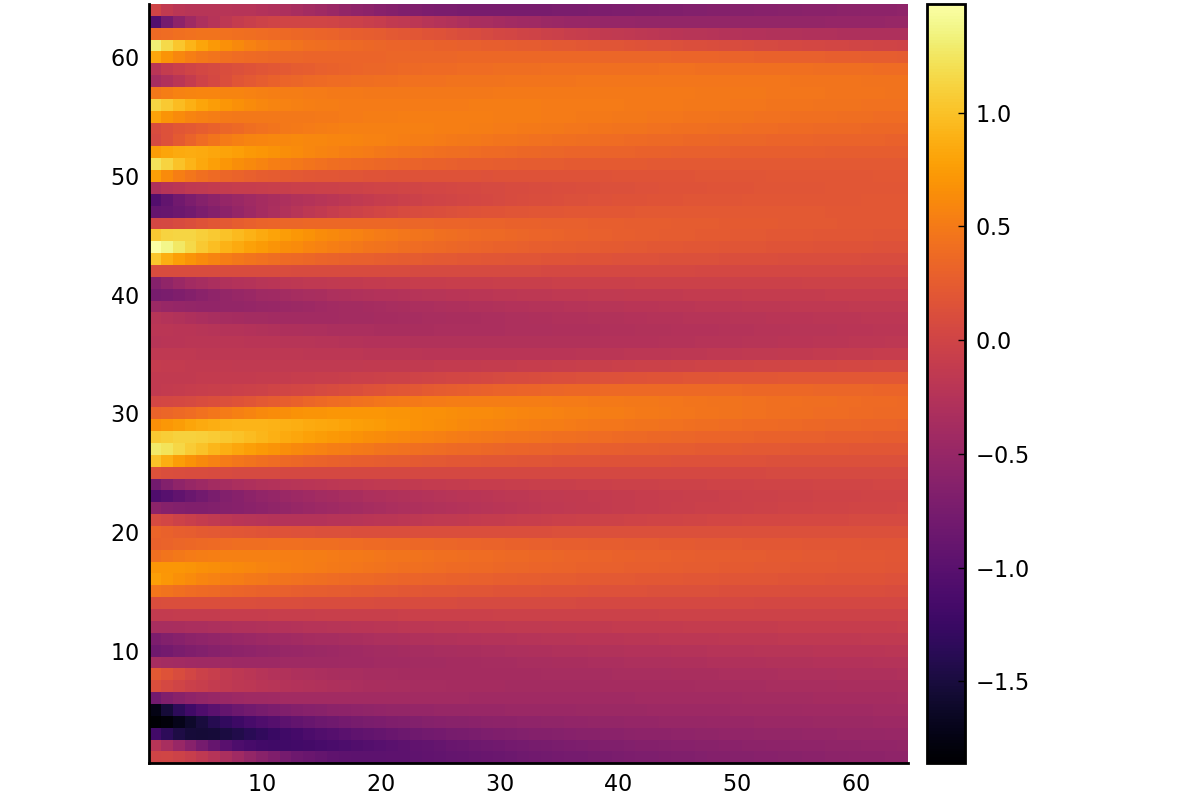

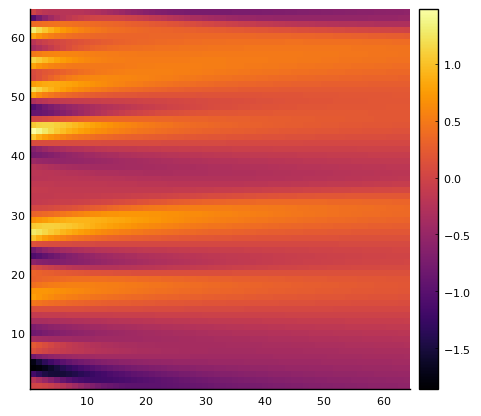

In [166]:
function check_training_dataset(dataset)
    for i in range(1, 3, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(high_dataset)

--- 
# Training with NeuralODE object (DISCARDED)

In [ ]:
callback(theta, loss, u) = (display(loss); false)

In [ ]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

## Experiment with different models

### Heat linear model

In [ ]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

In [ ]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [ ]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

In [ ]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

In [ ]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

--- 
### FNN

In [ ]:
# t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net2 = Models.BasicFNN(x_n);
result2 = burgers_training(net2, 100, init_set, true_set, t);

In [ ]:
check_result(net2, result2, 2)

### Basic Autoencoder

In [ ]:
net3 = Models.BasicAutoEncoder(x_n);
result3 = burgers_training(net3, 1000, init_set, true_set, t);

In [ ]:
check_result(net3, result3, 2)

## Analysis

In [ ]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

In [ ]:
println(test_simulation(net, result, 1000, 1))
println(test_simulation(net, result, 1000, 2))

In [ ]:
println(test_simulation(net2, result2, 1000, 1))
println(test_simulation(net2, result2, 1000, 2))

In [ ]:
println(test_simulation(net3, result3, 1000, 1))
println(test_simulation(net3, result3, 1000, 2))

--- 
# Training with flux

In [260]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(u0, res)

    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

In [266]:
function get_data_loader(dataset, batch_size, ratio)
  n = size(dataset, 1)
  t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);

  t_train, t_val = splitobs(t, at = ratio);
  train_set, val_set = splitobs(true_set, at = ratio);
  init_train = copy(init_set);
  init_val = copy(val_set[:, :, 1]);

  switch_train_set = permutedims(train_set, (1, 3, 2));
  switch_val_set = permutedims(val_set, (1, 3, 2));

  train_data = (init_train, switch_train_set, collect(ncycle([collect(t_train)], n)))
  val_data = (init_val, switch_val_set,  collect(ncycle([collect(t_val)], n))) #  hcat(repeat([collect(t_val)], n)...)
  
  train_loader = DataLoader(train_data, batchsize=batch_size, shuffle=true);
  val_loader = DataLoader(val_data, batchsize=batch_size, shuffle=false);

  return (train_loader, val_loader)
end

get_data_loader (generic function with 1 method)

In [247]:
function training(model, epochs, dataset, batch_size, ratio, noise=0., reg=0.)    
    # opt = Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8);
    opt = Flux.Optimiser(WeightDecay(reg), Flux.ADAM(0.01, (0.9, 0.999), 1.0e-8))
    ltrain = 0.;
    losses = [];
    
    @info("Loading dataset")
    (train_loader, val_loader) = get_data_loader(dataset, batch_size, ratio);

    @info("Building model")
    p, re = Flux.destructure(model);
    net(u, p, t) = re(p)(u);
    
    prob = ODEProblem{false}(net, Nothing, (Nothing, Nothing));
    
    function predict_neural_ode(x, t)
        tspan = (t[1], t[end]);
        _prob = remake(prob; u0=x, p=p, tspan=tspan);
        Array(solve(_prob, Tsit5(), u0=x, p=p, saveat=t));
    end
    
    function loss(x, y, t)
        u_pred = predict_neural_ode(x, t[1]);
        ŷ = Reg.gaussian_augment(u_pred, noise);
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2))); # + Reg.l2(p, reg);
        return l;
    end
    
    function traincb()
        ltrain = 0;
        for (x, y, t) in train_loader
             ltrain += loss(x, y, t);
        end
        ltrain /= (train_loader.nobs / train_loader.batchsize);
        @show(ltrain);
    end
        
    function val_loss(x, y, t)
        u_pred = predict_neural_ode(x, t[1]);
        ŷ = u_pred;
        l = Flux.mse(ŷ, permutedims(y, (1, 3, 2)))
        return l;
    end
    
    function evalcb()
        lval = 0;
        for (x, y, t) in val_loader
             lval += val_loss(x, y, t);
        end
        lval /= (val_loader.nobs / val_loader.batchsize);
        @show(lval);
    end
    
    @info("Train")
    trigger = Flux.plateau(() -> ltrain, 20; init_score = 1, min_dist = 1f-5);
    Flux.@epochs epochs begin
        Flux.train!(loss, Flux.params(p), train_loader, opt, cb = [traincb, evalcb]);
        trigger() && break;
    end

    return re(p), p
end

training (generic function with 3 methods)

In [249]:
function main()
  batch_size = 32;
  epochs = 100;

  data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
  model = Models.BasicAutoEncoder(x_n);
  K, p = training(model, epochs, data, batch_size, 0.5);
  # @save "./src/examples/burgers/models/BurgersLinearModel.bson" K
  return K, p
end

K, p = main()

┌ Info: Loading dataset
└ @ Main In[247]:7
┌ Info: Building model
└ @ Main In[247]:10
┌ Info: Train
└ @ Main In[247]:54
┌ Info: Epoch 1
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.45632995023400647
lval = 0.024609958754346038
ltrain = 0.44508151555029446
lval = 0.02348622017834085
ltrain = 0.4356791923564085
lval = 0.02256887282218689
ltrain = 0.42733031011311007
lval = 0.021784326354742464


┌ Info: Epoch 2
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.4201967492201651
lval = 0.021284372758193282
ltrain = 0.4138743658318518
lval = 0.02093371732428701
ltrain = 0.40797970741369316
lval = 0.020672405006393793
ltrain = 0.4023532344658418
lval = 0.02045714846808894


┌ Info: Epoch 3
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3970352826518688
lval = 0.020297014420484816
ltrain = 0.3918989770125471
lval = 0.020205391760660586
ltrain = 0.38692175901732634
lval = 0.020137560582079498
ltrain = 0.38205266534293947
lval = 0.020103186605788866


┌ Info: Epoch 4
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.37733294541244394
lval = 0.02010217052126026
ltrain = 0.37267694637334464
lval = 0.020113195351954022
ltrain = 0.36809560587555135
lval = 0.020088200448152405
ltrain = 0.36352878728812443
lval = 0.02001617375728114


┌ Info: Epoch 5
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.35903770890938835
lval = 0.01995906394203083
ltrain = 0.3546241103105302
lval = 0.019863736033246312
ltrain = 0.35027095757401705
lval = 0.019740626033101512
ltrain = 0.3460003169955026
lval = 0.01958467116018374


┌ Info: Epoch 6
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.34184686208181825
lval = 0.019415401285559405
ltrain = 0.3377962382350256
lval = 0.019255833474911353
ltrain = 0.3337651299866732
lval = 0.019085532693026763
ltrain = 0.3298188526019053
lval = 0.01891991250370585


┌ Info: Epoch 7
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.3259712505205489
lval = 0.01873932907049238
ltrain = 0.32218036399507205
lval = 0.018599806946110263
ltrain = 0.31847446389369793
lval = 0.01846614770424675
ltrain = 0.3148857350832097
lval = 0.018347050289490952


┌ Info: Epoch 8
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.31140376166801725
lval = 0.01823333970606263
ltrain = 0.30802594055825594
lval = 0.01814784814921075
ltrain = 0.3046850714344952
lval = 0.018075103500310476
ltrain = 0.30136105254621637
lval = 0.01799518312618206


┌ Info: Epoch 9
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.29811408976011716
lval = 0.01794539927317666
ltrain = 0.29494630759237817
lval = 0.017899298759102303
ltrain = 0.2918528114140722
lval = 0.01788509956343374
ltrain = 0.28880131416218713
lval = 0.017834052780976873


┌ Info: Epoch 10
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2858055518652224
lval = 0.017787677119760075
ltrain = 0.28289933486559954
lval = 0.017739883681893137
ltrain = 0.2800196065361768
lval = 0.017710244026217528
ltrain = 0.2772053593766025
lval = 0.017681490289042947


┌ Info: Epoch 11
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2744296527429579
lval = 0.017672513362301655
ltrain = 0.2717289974885114
lval = 0.017666899842757253
ltrain = 0.26905915854227874
lval = 0.017657146017983093
ltrain = 0.266422985324267
lval = 0.017625317484491337


┌ Info: Epoch 12
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.26383078840443586
lval = 0.017582909241182568
ltrain = 0.2613004812345521
lval = 0.017548638829458927
ltrain = 0.25879309889987107
lval = 0.017539776294385113
ltrain = 0.25630232914802054
lval = 0.017523262013474292


┌ Info: Epoch 13
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.25383317477619766
lval = 0.01754538108287501
ltrain = 0.2514120084873012
lval = 0.0175749773577281
ltrain = 0.24900781296921704
lval = 0.0175880632310067
ltrain = 0.24665299462923423
lval = 0.017586080165348298


┌ Info: Epoch 14
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.24434058612584042
lval = 0.017599636012983914
ltrain = 0.2420573650249182
lval = 0.01761660765293431
ltrain = 0.23977337008283783
lval = 0.01763207436479585
ltrain = 0.2375075628956954
lval = 0.017632502715243106


┌ Info: Epoch 15
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.23527719620435342
lval = 0.01763228061621261
ltrain = 0.23309996054746523
lval = 0.017639563680019024
ltrain = 0.23095014158466648
lval = 0.017632153483014584
ltrain = 0.2287488679446698
lval = 0.017644201485118204


┌ Info: Epoch 16
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2265755640119061
lval = 0.017637107885927143
ltrain = 0.2244457147490375
lval = 0.01761368818296388
ltrain = 0.22232103279157883
lval = 0.017628028708765106
ltrain = 0.22020559183060723
lval = 0.017657688441444806


┌ Info: Epoch 17
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.21813905877202366
lval = 0.01772830098835531
ltrain = 0.21610727869285998
lval = 0.01782037991625661
ltrain = 0.21408810671813566
lval = 0.017880605610767812
ltrain = 0.2120612702554818
lval = 0.01789661053638253


┌ Info: Epoch 18
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2100517052999588
lval = 0.017903771485257403
ltrain = 0.20809164064384003
lval = 0.017888721248245573
ltrain = 0.20611465035141907
lval = 0.017900598202587333
ltrain = 0.20418466238055247
lval = 0.017913327195064208


┌ Info: Epoch 19
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.2022786452805457
lval = 0.01794527323406612
ltrain = 0.20038350980488315
lval = 0.01795387706463408
ltrain = 0.1985195195381797
lval = 0.017949619408370608
ltrain = 0.19669417292755914
lval = 0.01795076759276115


┌ Info: Epoch 20
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.19491121956581048
lval = 0.01796790027033717
ltrain = 0.19314406441423343
lval = 0.017959197786829827
ltrain = 0.19139480218871802
lval = 0.017965032077030034
ltrain = 0.18966548313439519
lval = 0.017953195541324924


┌ Info: Epoch 21
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.18796818805091417
lval = 0.01799700398414387
ltrain = 0.1862913358373599
lval = 0.018041600505762027
ltrain = 0.1846438968659902
lval = 0.018031526710659114
ltrain = 0.1830262405443951
lval = 0.017991240030377442


┌ Info: Epoch 22
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1814373182289886
lval = 0.017946165450169915
ltrain = 0.1798921515861973
lval = 0.017899084775818863
ltrain = 0.1783712996982275
lval = 0.01789696274410399
ltrain = 0.17685270493638452
lval = 0.017866756635176596


┌ Info: Epoch 23
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1753416678026464
lval = 0.017862315719984416
ltrain = 0.17388730962693066
lval = 0.017853404416548455
ltrain = 0.17247465860733474
lval = 0.017819243739256294
ltrain = 0.1710507739401458
lval = 0.017796394000321274


┌ Info: Epoch 24
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.16965564825337678
lval = 0.017793639818053753
ltrain = 0.16828383994829743
lval = 0.017811990753232768
ltrain = 0.16694285623194383
lval = 0.01782770743560895
ltrain = 0.16561225395744525
lval = 0.017801636184360203


┌ Info: Epoch 25
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1643042429544585
lval = 0.017811023785225907
ltrain = 0.16303248668214296
lval = 0.017825600420411807
ltrain = 0.1617827957718934
lval = 0.017819485191770915
ltrain = 0.16053121330357872
lval = 0.017758606990152328


┌ Info: Epoch 26
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1593037087119503
lval = 0.017729866643161514
ltrain = 0.1581068924785179
lval = 0.01772645087658308
ltrain = 0.15693620414333906
lval = 0.017691362615668085
ltrain = 0.1557614402632915
lval = 0.017651517307237546


┌ Info: Epoch 27
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15462763318877515
lval = 0.01764835190596464
ltrain = 0.15350368368080966
lval = 0.0177069867857301
ltrain = 0.15240828968600578
lval = 0.017738618245606838
ltrain = 0.1513109937883819
lval = 0.01771423097604959


┌ Info: Epoch 28
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.15023350541886477
lval = 0.01772090604765814
ltrain = 0.14919030527918903
lval = 0.017722026749704887
ltrain = 0.14815542978593688
lval = 0.017713648221800216
ltrain = 0.14711481306035376
lval = 0.017661679296299554


┌ Info: Epoch 29
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14610862262619762
lval = 0.01764028164991303
ltrain = 0.1451307460932586
lval = 0.017689728079769616
ltrain = 0.14417602872112262
lval = 0.017702250148709527
ltrain = 0.1431979303791095
lval = 0.01767104928767816


┌ Info: Epoch 30
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.14225321604185676
lval = 0.017617788487788798
ltrain = 0.14133213215427173
lval = 0.017617146269649418
ltrain = 0.14042743099736246
lval = 0.01760054824273206
ltrain = 0.1395061234102488
lval = 0.017657834611924363


┌ Info: Epoch 31
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13860471305708905
lval = 0.017723036067789154
ltrain = 0.13773413759977318
lval = 0.017828109668956156
ltrain = 0.1368702189455948
lval = 0.01792039146332952
ltrain = 0.13600542310872749
lval = 0.017988365791692905


┌ Info: Epoch 32
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13518172595798444
lval = 0.018037249586144694
ltrain = 0.13437564579692482
lval = 0.01805886252447214
ltrain = 0.13357481631625015
lval = 0.018087082903095467
ltrain = 0.13274853331427144
lval = 0.018099758705239208


┌ Info: Epoch 33
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.13195701409886024
lval = 0.018104741715340763
ltrain = 0.13119438676039524
lval = 0.018117562895910412
ltrain = 0.1304276803741825
lval = 0.01813159800210399
ltrain = 0.12965274242803748
lval = 0.018138350558530893


┌ Info: Epoch 34
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12891209751949625
lval = 0.018189237169421023
ltrain = 0.12819211733048777
lval = 0.018225963359979603
ltrain = 0.1274765488424456
lval = 0.018202866455989238
ltrain = 0.1267351188780454
lval = 0.01823605827191254


┌ Info: Epoch 35
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12602922136711198
lval = 0.018334638390323975
ltrain = 0.12536354718042467
lval = 0.018441195492136905
ltrain = 0.12468134206134486
lval = 0.018514105304733228
ltrain = 0.12399018030386494
lval = 0.018501445855277156


┌ Info: Epoch 36
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1233312793689033
lval = 0.018528352122166046
ltrain = 0.12270843061457179
lval = 0.01857130620305999
ltrain = 0.12207433854920045
lval = 0.01850379701221664
ltrain = 0.12141281154791356
lval = 0.01842582523186636


┌ Info: Epoch 37
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.12077336070934641
lval = 0.018347718857979547
ltrain = 0.12018954150095426
lval = 0.01828018996949221
ltrain = 0.11959832761257691
lval = 0.018279425960065154
ltrain = 0.11895569917707438
lval = 0.018285247626649345


┌ Info: Epoch 38
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1183418944802638
lval = 0.018352094177791416
ltrain = 0.11776101787722837
lval = 0.01848194828015296
ltrain = 0.11720385155518602
lval = 0.01863051992050008
ltrain = 0.11663792854386142
lval = 0.018680189093702733


┌ Info: Epoch 39
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11609268751236011
lval = 0.01872057518890684
ltrain = 0.11555048604735685
lval = 0.018758752655784715
ltrain = 0.11497956338057636
lval = 0.018724741789370572
ltrain = 0.11442193708961806
lval = 0.018666597219085465


┌ Info: Epoch 40
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11390541018001929
lval = 0.018634211400778602
ltrain = 0.11342823764553428
lval = 0.018629752041573223
ltrain = 0.11294789758328067
lval = 0.018649506192562247
ltrain = 0.11239589998329143
lval = 0.018682788805559156


┌ Info: Epoch 41
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11187836110041366
lval = 0.01876822786731437
ltrain = 0.1114277933362089
lval = 0.018938976708919752
ltrain = 0.1109650812595519
lval = 0.018975245980475272
ltrain = 0.11047103381014269
lval = 0.01890264851401092


┌ Info: Epoch 42
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.11000911058413358
lval = 0.01880283560463802
ltrain = 0.10956096229937795
lval = 0.018698793682889438
ltrain = 0.10911982860218647
lval = 0.018607094599898517
ltrain = 0.10865012304774713
lval = 0.01851883615600488


┌ Info: Epoch 43
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10823182291564462
lval = 0.018486719784929564
ltrain = 0.10785742220192875
lval = 0.01854093206043122
ltrain = 0.10746955396983998
lval = 0.018568608416388237
ltrain = 0.10700108365091524
lval = 0.018630399353697858


┌ Info: Epoch 44
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10657085221752735
lval = 0.018706835072356667
ltrain = 0.10622051918143449
lval = 0.01881636405620824
ltrain = 0.10587540664795664
lval = 0.018893335413753702
ltrain = 0.10544633054583866
lval = 0.018888032538614992


┌ Info: Epoch 45
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10506479766933882
lval = 0.018879914696104862
ltrain = 0.1046981914878303
lval = 0.018853076387584652
ltrain = 0.10433021493840801
lval = 0.0188571525612099
ltrain = 0.10393850241164176
lval = 0.018746315418956966


┌ Info: Epoch 46
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10359734338458856
lval = 0.018661542451189735
ltrain = 0.10329987422322257
lval = 0.018650838973124473
ltrain = 0.10296214838331087
lval = 0.018636650982997577
ltrain = 0.10256637097546767
lval = 0.018638083543528135


┌ Info: Epoch 47
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.1022147634447871
lval = 0.018620489540226694
ltrain = 0.10188528838086727
lval = 0.018608766970780677
ltrain = 0.10155221082473175
lval = 0.01864000078652132
ltrain = 0.10122423800890851
lval = 0.018668934469092967


┌ Info: Epoch 48
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.10091377496551186
lval = 0.018687551146664885
ltrain = 0.10060999893060338
lval = 0.018599045750153323
ltrain = 0.10027680734405159
lval = 0.018530882936049577
ltrain = 0.0999426846701928
lval = 0.01851392309852786


┌ Info: Epoch 49
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09963204750982228
lval = 0.018525507244069688
ltrain = 0.09935559270802061
lval = 0.018599613814946306
ltrain = 0.09910077297309901
lval = 0.018711794493902364
ltrain = 0.0987895625417633
lval = 0.018673994034783446


┌ Info: Epoch 50
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09850805021266046
lval = 0.01873407005298639
ltrain = 0.09823017177108458
lval = 0.018797286094103728
ltrain = 0.0979396665463484
lval = 0.0187765432480086
ltrain = 0.09765313280567609
lval = 0.018630842513308352


┌ Info: Epoch 51
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09742103659610014
lval = 0.018391507089492155
ltrain = 0.0972125656786344
lval = 0.018260024045095333
ltrain = 0.09695609498388175
lval = 0.018251459837713854
ltrain = 0.09663894307920724
lval = 0.018317307864684013


┌ Info: Epoch 52
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09640011412050238
lval = 0.018465697048669474
ltrain = 0.09620217029472389
lval = 0.018637506111779337
ltrain = 0.09597546531731264
lval = 0.018777366071944523
ltrain = 0.095652643119095
lval = 0.01867008080879597


┌ Info: Epoch 53
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09540201376462698
lval = 0.018610952534571075
ltrain = 0.0951738855165698
lval = 0.018464619580540444
ltrain = 0.09498748496423988
lval = 0.01838076717640499
ltrain = 0.09474593876202385
lval = 0.018282190369398356


┌ Info: Epoch 54
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09455284732647168
lval = 0.018226364847070256
ltrain = 0.0943496030571526
lval = 0.018226483284963502
ltrain = 0.09406904609958405
lval = 0.01829785680359157
ltrain = 0.09383115926412565
lval = 0.018383840142193686


┌ Info: Epoch 55
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09363772174254509
lval = 0.01849908366854355
ltrain = 0.09346790894028704
lval = 0.018600574570230476
ltrain = 0.09323151601520627
lval = 0.01851961497420869
ltrain = 0.0929223327248478
lval = 0.01838292226957113


┌ Info: Epoch 56
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09269975077659466
lval = 0.0183209245481349
ltrain = 0.09254325533218405
lval = 0.018327821951121412
ltrain = 0.09239569392473729
lval = 0.018389057897824683
ltrain = 0.09214601546936928
lval = 0.018305629665977825


┌ Info: Epoch 57
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09194275860298974
lval = 0.018316022155630378
ltrain = 0.09179024666334738
lval = 0.01842978087421073
ltrain = 0.09159939485416362
lval = 0.018389127241610542
ltrain = 0.09130294442246452
lval = 0.0182959384499418


┌ Info: Epoch 58
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09111494078775678
lval = 0.018280226363072048
ltrain = 0.09095415583823831
lval = 0.018263026536706806
ltrain = 0.09079091759207467
lval = 0.018289028343067712
ltrain = 0.09055851198849488
lval = 0.018277651375964685


┌ Info: Epoch 59
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.09032037676117306
lval = 0.01826451735137285
ltrain = 0.09014530866084768
lval = 0.018280798031005484
ltrain = 0.08998699272006111
lval = 0.018291818823998145
ltrain = 0.08979358878401723
lval = 0.01831889080508443


┌ Info: Epoch 60
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08960230474977512
lval = 0.018291070901025937
ltrain = 0.08943003815443006
lval = 0.018325338715629372
ltrain = 0.08927443586042945
lval = 0.018331410081351397
ltrain = 0.08904311026613403
lval = 0.01832423988977441


┌ Info: Epoch 61
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.088852992909035
lval = 0.01828413656326401
ltrain = 0.08870023292828208
lval = 0.018291112635452196
ltrain = 0.08853736950161387
lval = 0.01821550487412784
ltrain = 0.08833359319979942
lval = 0.01816535866163312


┌ Info: Epoch 62
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08816579020020066
lval = 0.018116637489243612
ltrain = 0.0880100743065113
lval = 0.018087185168794262
ltrain = 0.08781352265508399
lval = 0.01811322934717078
ltrain = 0.08762173270125737
lval = 0.0181058606543007


┌ Info: Epoch 63
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08748020487084568
lval = 0.018165653653817518
ltrain = 0.0873529646390118
lval = 0.018205930147578514
ltrain = 0.08717595885113488
lval = 0.01818796322174669
ltrain = 0.08695417715791748
lval = 0.018170459157999728


┌ Info: Epoch 64
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08682160046640043
lval = 0.018214349997449218
ltrain = 0.08673688180578323
lval = 0.018275068905537886
ltrain = 0.0865749462234944
lval = 0.018309620469276904
ltrain = 0.08633298128479262
lval = 0.01826267215789699


┌ Info: Epoch 65
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08617970194527337
lval = 0.018278241924999616
ltrain = 0.08613915552814447
lval = 0.018315533798179524
ltrain = 0.08605373658050816
lval = 0.018340053986840296
ltrain = 0.08581706350960822
lval = 0.01818044930564404


┌ Info: Epoch 66
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0855711135869521
lval = 0.018026020090517764
ltrain = 0.08540978565893229
lval = 0.018046704162203605
ltrain = 0.08527896254190132
lval = 0.018104920424419555
ltrain = 0.08515437593669208
lval = 0.018237269726697373


┌ Info: Epoch 67
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08502547100341087
lval = 0.01832092020255542
ltrain = 0.08488928062817072
lval = 0.018404024586275356
ltrain = 0.08469809714257492
lval = 0.01835743855368144
ltrain = 0.08447043540383617
lval = 0.01825389091490872


┌ Info: Epoch 68
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08436604753574496
lval = 0.018272565395737034
ltrain = 0.0843041206253504
lval = 0.018299747157734435
ltrain = 0.08416967236175299
lval = 0.018339671027337905
ltrain = 0.08392171941293117
lval = 0.018271678004183133


┌ Info: Epoch 69
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0837259788141225
lval = 0.01822084218097161
ltrain = 0.08363858898442383
lval = 0.018257170907627726
ltrain = 0.08358125171943648
lval = 0.018433138927518848
ltrain = 0.08340655412079782
lval = 0.018390151535577996


┌ Info: Epoch 70
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08321513750654262
lval = 0.018277562272714352
ltrain = 0.0830904092675067
lval = 0.0181630670067993
ltrain = 0.08299124627566497
lval = 0.018177479787447756
ltrain = 0.08284846427320147
lval = 0.0182006745441539


┌ Info: Epoch 71
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08273540644252511
lval = 0.018293984142928113
ltrain = 0.0825869228747205
lval = 0.018370269256807535
ltrain = 0.08240009657701691
lval = 0.01839357962280958
ltrain = 0.08218383895251793
lval = 0.018314785974883917


┌ Info: Epoch 72
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08209927893239152
lval = 0.01833922513466319
ltrain = 0.08203883801395362
lval = 0.01835775514224545
ltrain = 0.08189788246603172
lval = 0.018199607476933957
ltrain = 0.08173511308347775
lval = 0.018101991840711686


┌ Info: Epoch 73
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08160838493594388
lval = 0.01805919807169317
ltrain = 0.08151819528711335
lval = 0.01791882581957899
ltrain = 0.08136167898513166
lval = 0.017873112080989222
ltrain = 0.08116630980889164
lval = 0.01796495734315392


┌ Info: Epoch 74
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08104834962941163
lval = 0.018099975048833122
ltrain = 0.0809919337752512
lval = 0.018291027444330817
ltrain = 0.08087882573859428
lval = 0.018488635627628813
ltrain = 0.08070441408401294
lval = 0.018575676268469482


┌ Info: Epoch 75
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08052729087451857
lval = 0.01861726636475977
ltrain = 0.08040448132505262
lval = 0.018620909142153363
ltrain = 0.08033093581664599
lval = 0.0185928734607987
ltrain = 0.08016236963091507
lval = 0.018420050615267552


┌ Info: Epoch 76
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.08009103750689348
lval = 0.01823475435199516
ltrain = 0.0799587327943033
lval = 0.01820730209524752
ltrain = 0.07980822582232643
lval = 0.018250701604569743
ltrain = 0.07960544957636209
lval = 0.018268703989443275


┌ Info: Epoch 77
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07948700447511745
lval = 0.01838971938729861
ltrain = 0.07932016882552853
lval = 0.018360192690217495
ltrain = 0.0791760024569026
lval = 0.018327017862355646
ltrain = 0.07903262725876077
lval = 0.01828782858007899


┌ Info: Epoch 78
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07892200884510195
lval = 0.01833831655188085
ltrain = 0.07879862478182698
lval = 0.018308595004451252
ltrain = 0.07865805913827073
lval = 0.01824370416595735
ltrain = 0.0785015359800737
lval = 0.01820723462606306


┌ Info: Epoch 79
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07839104986185447
lval = 0.018193747860462538
ltrain = 0.07831427651466745
lval = 0.01823039560642074
ltrain = 0.07816815621796536
lval = 0.01813459693552246
ltrain = 0.07798256829338335
lval = 0.018127598307200992


┌ Info: Epoch 80
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07791694137613976
lval = 0.018195720921478076
ltrain = 0.07788606574625451
lval = 0.018318784960364036
ltrain = 0.0777323679128968
lval = 0.01824983333225455
ltrain = 0.07748658775734436
lval = 0.018202946715117036


┌ Info: Epoch 81
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07733064779886759
lval = 0.018267305682332993
ltrain = 0.07728458699217013
lval = 0.01834555548194014
ltrain = 0.07723381622676984
lval = 0.018393157133776986
ltrain = 0.07709353441545577
lval = 0.01840661762150159


┌ Info: Epoch 82
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07696996668980449
lval = 0.018470103118599687
ltrain = 0.07685984144130203
lval = 0.018494913462314667
ltrain = 0.07668310824557842
lval = 0.018408451032512103
ltrain = 0.07651189373113801
lval = 0.018308175538211964


┌ Info: Epoch 83
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07645797031615617
lval = 0.01839039458776282
ltrain = 0.07647253751320911
lval = 0.018481976757100938
ltrain = 0.07638830109007735
lval = 0.018533155237563322
ltrain = 0.07613576607602901
lval = 0.018386626463870816


┌ Info: Epoch 84
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07597833052569866
lval = 0.01835058444811699
ltrain = 0.07591957898119842
lval = 0.01841824238281251
ltrain = 0.07594516066669577
lval = 0.01858999161378177
ltrain = 0.07571574869463443
lval = 0.018522800159414883


┌ Info: Epoch 85
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0754935065057539
lval = 0.018325434023741767
ltrain = 0.0754790576532494
lval = 0.018330877387846084
ltrain = 0.07552033927318008
lval = 0.018397089257884514
ltrain = 0.07534468630522985
lval = 0.018333850838519003


┌ Info: Epoch 86
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07513766203645936
lval = 0.018351031986433647
ltrain = 0.07498101355202189
lval = 0.01835263083077531
ltrain = 0.07486969254541184
lval = 0.018373393434164196
ltrain = 0.07474686484115728
lval = 0.01838108951799945


┌ Info: Epoch 87
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07464913339157188
lval = 0.018363978072579952
ltrain = 0.07455609597097923
lval = 0.01826481374439175
ltrain = 0.0744535022678357
lval = 0.01827942084385043
ltrain = 0.07426547574560693
lval = 0.01837553379358309


┌ Info: Epoch 88
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0741865119948705
lval = 0.018548229839256115
ltrain = 0.07412701250859426
lval = 0.018719794775157183
ltrain = 0.07403672416592669
lval = 0.01884635396895066
ltrain = 0.07378996394995757
lval = 0.018765642180414918


┌ Info: Epoch 89
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07367514608788082
lval = 0.018643543416922127
ltrain = 0.07361982612097835
lval = 0.018513735432116967
ltrain = 0.07344305233272322
lval = 0.018377573724922984
ltrain = 0.07331345990628728
lval = 0.01830725870294735


┌ Info: Epoch 90
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07329057883755641
lval = 0.018359655975024848
ltrain = 0.07322698132166339
lval = 0.018437807434144856
ltrain = 0.07296150653615108
lval = 0.01842618673566122
ltrain = 0.07279021095423449
lval = 0.018533758760173758


┌ Info: Epoch 91
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0727873540658052
lval = 0.018773940819373357
ltrain = 0.07274675816014331
lval = 0.018979388708398492
ltrain = 0.07247171187704782
lval = 0.018855222416773964
ltrain = 0.07253025233929848
lval = 0.018955988803012642


┌ Info: Epoch 92
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07250646163041538
lval = 0.01892743235172318
ltrain = 0.07230450192910683
lval = 0.01872800334251625
ltrain = 0.07205318630810845
lval = 0.018438027384853502
ltrain = 0.07183012377846684
lval = 0.018197350185827285


┌ Info: Epoch 93
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07184554368405634
lval = 0.018346674314698982
ltrain = 0.0718222862289288
lval = 0.01844976030572908
ltrain = 0.07161905895749461
lval = 0.01831685493487957
ltrain = 0.07143437946814171
lval = 0.01828031620982555


┌ Info: Epoch 94
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0713887525290258
lval = 0.018421823028012832
ltrain = 0.0713623365716573
lval = 0.018715014512860017
ltrain = 0.07121754916722287
lval = 0.018853896419148503
ltrain = 0.07097038290892524
lval = 0.01886392925535688


┌ Info: Epoch 95
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07090337757034756
lval = 0.018924479679922557
ltrain = 0.07091931294952639
lval = 0.018966032171811885
ltrain = 0.07080906124897632
lval = 0.01879031926183093
ltrain = 0.07056362231066354
lval = 0.018521295473977985


┌ Info: Epoch 96
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.07035628847140724
lval = 0.018302109905406195
ltrain = 0.07031697263923725
lval = 0.01816641088890878
ltrain = 0.07024590771808806
lval = 0.018056492494710193
ltrain = 0.07009124342768724
lval = 0.018072462907252854


┌ Info: Epoch 97
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06999722821555487
lval = 0.018259683297374617
ltrain = 0.06997163137647233
lval = 0.0185162540135825
ltrain = 0.06987126460096404
lval = 0.01873682425524944
ltrain = 0.06964400732163835
lval = 0.018699362608931236


┌ Info: Epoch 98
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06962868935852598
lval = 0.018763448614627386
ltrain = 0.06955509631900224
lval = 0.018784977186219076
ltrain = 0.06937638499034142
lval = 0.018626780862739244
ltrain = 0.06916842278158342
lval = 0.018506800186162766


┌ Info: Epoch 99
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.06914530917735971
lval = 0.018549472888851164
ltrain = 0.06909366996922964
lval = 0.01868182316153487
ltrain = 0.06884585086225979
lval = 0.018649258297600776
ltrain = 0.06865748600164534
lval = 0.018540352005429042


┌ Info: Epoch 100
└ @ Main /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:154


ltrain = 0.0685786978051039
lval = 0.01848746919162237
ltrain = 0.06856281926941107
lval = 0.018544096949457564
ltrain = 0.06844106983561123
lval = 0.018587713807711025
ltrain = 0.06822802897565461
lval = 0.01853830120069174


(Chain(Dense(64 => 32, tanh), Dense(32 => 16, tanh), Dense(16 => 32, tanh), Dense(32 => 64)), Float32[0.15427606, -0.1694295, 0.34540164, 0.21180962, -0.19333287, -0.015136319, -0.2349639, -0.15753578, -0.102914445, 0.041084148  …  -0.041955296, -0.2926889, 0.29889992, 0.9994722, 0.6625966, 0.15529245, 0.3464429, 1.1381599, 1.1966664, -0.6711323])

In [190]:
@save "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K
# @load "./src/examples/burgers/models/BurgersBasicAutoEncoderModel.bson" K

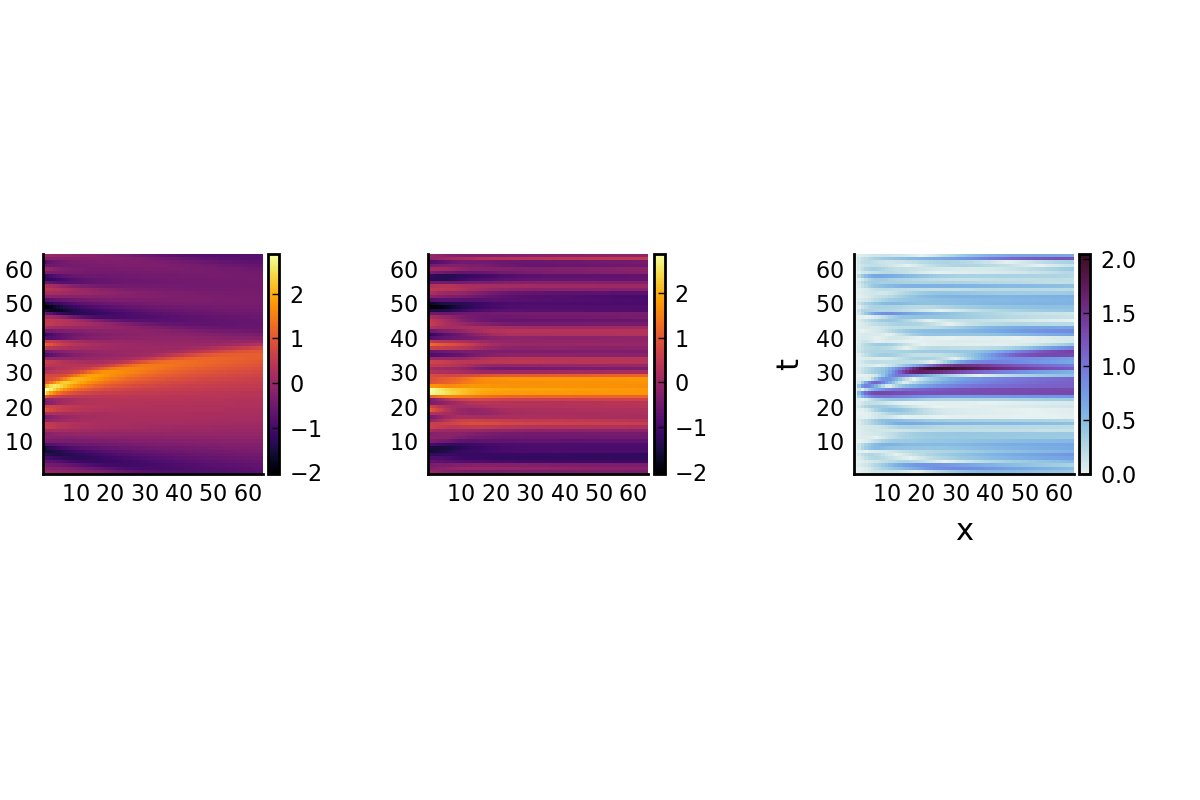

In [265]:
check_result(K, p, 2)

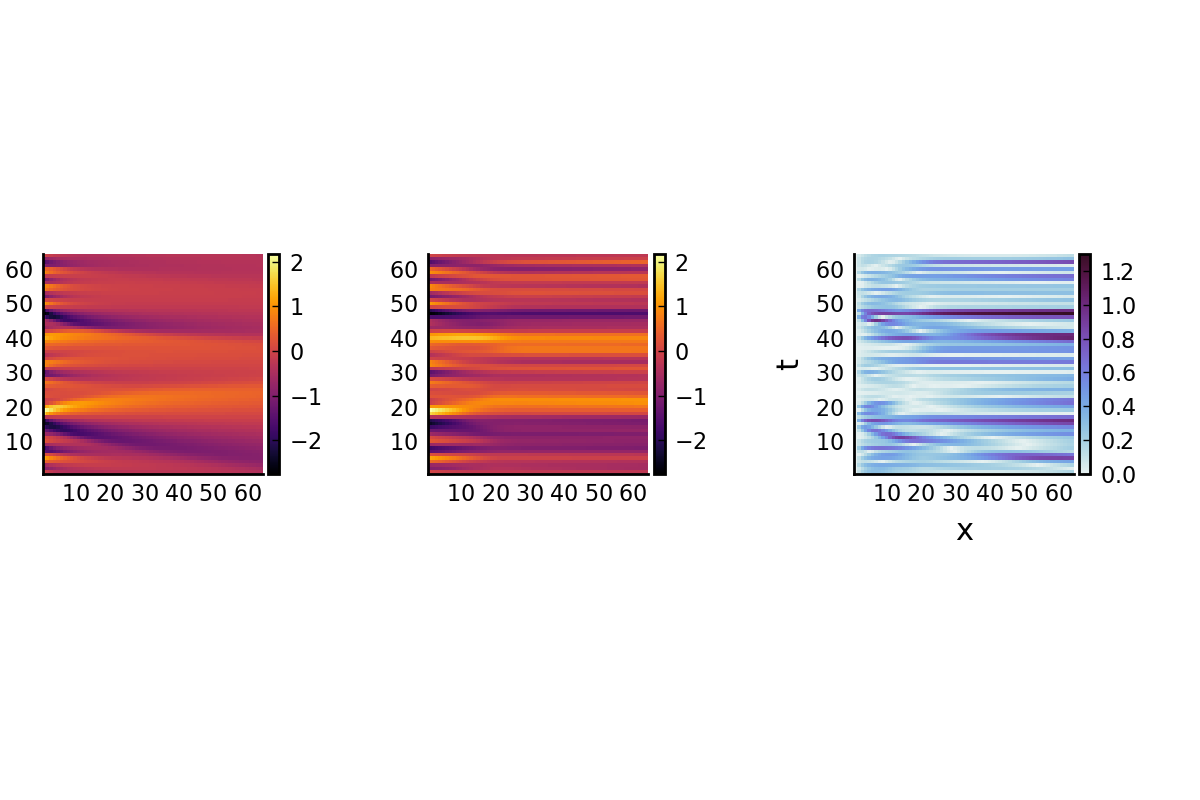

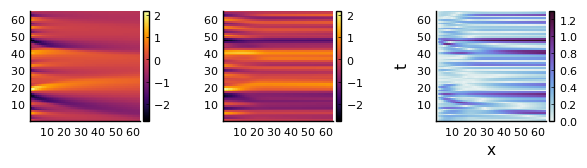

In [258]:
data = Generator.read_dataset("./src/examples/burgers/dataset/burgers_high_dim_training_set.jld2")["training_set"];
t, u0, u = ProcessingTools.process_dataset(data, false);
prob_neuralode = DiffEqFlux.NeuralODE(K, (t[1], t[end]), Tsit5(), saveat=t);
i = 9
u_pred = prob_neuralode(u0[:, i], p);
display(
    plot(
        GraphicTools.show_state(u[:, i, :], ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u[:, i, :], "");
        layout = (1, 3),
    )
)